In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval

In [2]:
STORE_PATH = '/home/pstefanou/knownVsUnknown'
STORE_TABLE_NAME = 'rebuttal3'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/knownVsUnknown/180e8af5-3bd2-418b-950f-036e41dc463d


In [9]:
# regression parameters
num_samples, dims = 1000, 10
# noise_var = Tensor([9.0])
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
phi = Left(Tensor([1.0]))


# perform each experiment a total of 10 times
for iter_ in range(10):        
    for var in range(1, 10):
        # generate data
        X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([num_samples]))
        # truncate
        # phi = Interval(Tensor([1.0]), Tensor([2.0]))
        indices = phi(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]


        # truncated linear regression with known noise variance
        reg = LinearRegression() 
        reg.fit(x_trunc, y_trunc)
        emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)

        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/num_samples]), 
            'phi': phi, 
            'epochs': 50,
            'num_workers': 2, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'lr': 1e-1,
            'unknown': False, 
            'var': emp_var,
            'shuffle': True
        })


        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=args.unknown)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)

        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=num_samples, var=args.var)
        results = trunc_reg.fit(S)
        w_ = results.weight.detach()
        w0_ = results.bias.detach()

        # truncated linear regression with unknown noise variance
        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/num_samples]), 
            'phi': phi, 
            'epochs': 50,
            'num_workers': 2, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'var_lr': 1e-2,
            'lr': 1e-1,
            'unknown': True, 
            'shuffle': True
        })

        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=args.unknown)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)

        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=num_samples, var=args.var)

        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach().cpu()
        w = results.v.detach().cpu()*var_
        w0 = results.bias.detach().cpu()*var_
        
        # calculate metrics 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        unknown_params = ch.cat([w, w0])
        known_params = ch.cat([w_.t(), w0_.unsqueeze(0)])
        unknown_param_mse = mean_squared_error(unknown_params, real_params)
        ols_param_mse = mean_squared_error(ols_params, real_params)
        known_param_mse = mean_squared_error(known_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'ols_param_mse': ols_param_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(var), 
        })

# close current store
store.close()

Epoch:1 | Loss 0.2326 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s]
Epoch:2 | Loss 0.2326 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]
Epoch:3 | Loss 0.2331 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.11it/s]
Epoch:4 | Loss 0.2332 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
Epoch:5 | Loss 0.2352 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.31it/s]
Epoch:6 | Loss 0.2395 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]
Epoch:7 | Loss 0.2455 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s]
Epoch:8 | Loss 0.2531 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.33it/s]
Epoch:9 | Loss 0.2620 | Train1 0.274 | Train5 -1

Epoch:19 | Loss 0.2407 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]
Epoch:20 | Loss 0.2397 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]
Epoch:21 | Loss 0.2391 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]
Epoch:22 | Loss 0.2400 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]
Epoch:23 | Loss 0.2406 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]
Epoch:24 | Loss 0.2403 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]
Epoch:25 | Loss 0.2401 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]
Epoch:26 | Loss 0.2409 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]
Epoch:27 | Loss 0.2399 | Train1 0.274 | 

Epoch:37 | Loss 0.5072 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.27it/s]
Epoch:38 | Loss 0.5070 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.78it/s]
Epoch:39 | Loss 0.5068 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.48it/s]
Epoch:40 | Loss 0.5078 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.73it/s]
Epoch:41 | Loss 0.5070 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]
Epoch:42 | Loss 0.5060 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.43it/s]
Epoch:43 | Loss 0.5068 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]
Epoch:44 | Loss 0.5073 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.61it/s]
Epoch:45 | Loss 0.5073 | Train1 0.230 | 

Epoch:5 | Loss 0.6146 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]
Epoch:6 | Loss 0.6156 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]
Epoch:7 | Loss 0.6166 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]
Epoch:8 | Loss 0.6174 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s]
Epoch:9 | Loss 0.6197 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.78it/s]
Epoch:10 | Loss 0.6213 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]
Epoch:11 | Loss 0.6232 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s]
Epoch:12 | Loss 0.6228 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s]
Epoch:13 | Loss 0.6254 | Train1 0.177 | Train

Epoch:23 | Loss 0.6464 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.28it/s]
Epoch:24 | Loss 0.6420 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]
Epoch:25 | Loss 0.6422 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.84it/s]
Epoch:26 | Loss 0.6531 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.24it/s]
Epoch:27 | Loss 0.6554 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]
Epoch:28 | Loss 0.6613 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.11it/s]
Epoch:29 | Loss 0.6700 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 40.32it/s]
Epoch:30 | Loss 0.6657 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]
Epoch:31 | Loss 0.6576 | Train1 0.177 | 

Epoch:41 | Loss 0.8413 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.52it/s]
Epoch:42 | Loss 0.8416 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]
Epoch:43 | Loss 0.8415 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.70it/s]
Epoch:44 | Loss 0.8412 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]
Epoch:45 | Loss 0.8414 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.41it/s]
Epoch:46 | Loss 0.8417 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s]
Epoch:47 | Loss 0.8413 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.64it/s]
Epoch:48 | Loss 0.8415 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s]
Epoch:49 | Loss 0.8414 | Train1 0.192 | 

Epoch:9 | Loss 1.0067 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.74it/s]
Epoch:10 | Loss 1.0043 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.22it/s]
Epoch:11 | Loss 1.0051 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.63it/s]
Epoch:12 | Loss 1.0085 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.76it/s]
Epoch:13 | Loss 1.0080 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.04it/s]
Epoch:14 | Loss 1.0118 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.13it/s]
Epoch:15 | Loss 1.0058 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
Epoch:16 | Loss 1.0077 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.38it/s]
Epoch:17 | Loss 1.0026 | Train1 0.160 | T

Epoch:27 | Loss 1.3951 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.20it/s]
Epoch:28 | Loss 1.4276 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.46it/s]
Epoch:29 | Loss 1.3396 | Train1 0.153 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.06it/s]
Epoch:30 | Loss 1.3249 | Train1 0.153 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.15it/s]
Epoch:31 | Loss 1.3979 | Train1 0.153 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.08it/s]
Epoch:32 | Loss 1.4148 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.12it/s]
Epoch:33 | Loss 1.4005 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.21it/s]
Epoch:34 | Loss 1.3621 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.41it/s]
Epoch:35 | Loss 1.4372 | Train1 0.149 | 

Epoch:45 | Loss 1.1702 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.04it/s]
Epoch:46 | Loss 1.1705 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.37it/s]
Epoch:47 | Loss 1.1705 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.75it/s]
Epoch:48 | Loss 1.1705 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.59it/s]
Epoch:49 | Loss 1.1704 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.65it/s]
Epoch:50 | Loss 1.1704 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.23it/s]
Epoch:1 | Loss 1.1654 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.51it/s]
Epoch:2 | Loss 1.1666 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.96it/s]
Epoch:3 | Loss 1.1681 | Train1 0.142 | Tra

Epoch:13 | Loss 1.4254 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.39it/s]
Epoch:14 | Loss 1.4297 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 11.59it/s]
Epoch:15 | Loss 1.4293 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.92it/s]
Epoch:16 | Loss 1.4376 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.17it/s]
Epoch:17 | Loss 1.4281 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.42it/s]
Epoch:18 | Loss 1.4321 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.99it/s]
Epoch:19 | Loss 1.4292 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.60it/s]
Epoch:20 | Loss 1.4307 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.61it/s]
Epoch:21 | Loss 1.4261 | Train1 0.157 | 

Epoch:31 | Loss 2.2693 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.23it/s]
Epoch:32 | Loss 2.5112 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.62it/s]
Epoch:33 | Loss 2.3066 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  8.66it/s]
Epoch:34 | Loss 2.4326 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.55it/s]
Epoch:35 | Loss 2.4829 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.54it/s]
Epoch:36 | Loss 2.3367 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.05it/s]
Epoch:37 | Loss 3.1428 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.28it/s]
Epoch:38 | Loss 2.4609 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.38it/s]
Epoch:39 | Loss 3.0035 | Train1 0.147 | 

Epoch:49 | Loss 1.6344 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
Epoch:50 | Loss 1.6343 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.11it/s]
Epoch:1 | Loss 1.6331 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.68it/s]
Epoch:2 | Loss 1.6332 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.46it/s]
Epoch:3 | Loss 1.6383 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.72it/s]
Epoch:4 | Loss 1.6424 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.60it/s]
Epoch:5 | Loss 1.6705 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.93it/s]
Epoch:6 | Loss 1.6695 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.73it/s]
Epoch:7 | Loss 1.6885 | Train1 0.122 | Train5 

Epoch:17 | Loss 1.6750 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]
Epoch:18 | Loss 1.6771 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]
Epoch:19 | Loss 1.6756 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.42it/s]
Epoch:20 | Loss 1.6763 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.79it/s]
Epoch:21 | Loss 1.6772 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.14it/s]
Epoch:22 | Loss 1.6755 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s]
Epoch:23 | Loss 1.6751 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]
Epoch:24 | Loss 1.6759 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s]
Epoch:25 | Loss 1.6748 | Train1 0.134 | 

Epoch:35 | Loss 2.5733 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]
Epoch:36 | Loss 2.5163 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]
Epoch:37 | Loss 2.6558 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]
Epoch:38 | Loss 2.6328 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]
Epoch:39 | Loss 2.4826 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]
Epoch:40 | Loss 2.5215 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]
Epoch:41 | Loss 2.4212 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]
Epoch:42 | Loss 2.6261 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]
Epoch:43 | Loss 2.4210 | Train1 0.134 | 

Epoch:3 | Loss 0.2713 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.36it/s]
Epoch:4 | Loss 0.2714 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.71it/s]
Epoch:5 | Loss 0.2717 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.30it/s]
Epoch:6 | Loss 0.2723 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.39it/s]
Epoch:7 | Loss 0.2727 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.32it/s]
Epoch:8 | Loss 0.2745 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.31it/s]
Epoch:9 | Loss 0.2749 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.15it/s]
Epoch:10 | Loss 0.2755 | Train1 0.254 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.85it/s]
Epoch:11 | Loss 0.2788 | Train1 0.254 | Train5 

Epoch:21 | Loss 0.4646 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]
Epoch:22 | Loss 0.4655 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s]
Epoch:23 | Loss 0.4673 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s]
Epoch:24 | Loss 0.4656 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.14it/s]
Epoch:25 | Loss 0.4682 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.66it/s]
Epoch:26 | Loss 0.4681 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.63it/s]
Epoch:27 | Loss 0.4681 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.24it/s]
Epoch:28 | Loss 0.4694 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.52it/s]
Epoch:29 | Loss 0.4691 | Train1 0.207 | 

Epoch:39 | Loss 0.4576 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.50it/s]
Epoch:40 | Loss 0.4563 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.13it/s]
Epoch:41 | Loss 0.4564 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.10it/s]
Epoch:42 | Loss 0.4576 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.95it/s]
Epoch:43 | Loss 0.4580 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]
Epoch:44 | Loss 0.4566 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]
Epoch:45 | Loss 0.4554 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.86it/s]
Epoch:46 | Loss 0.4566 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.66it/s]
Epoch:47 | Loss 0.4564 | Train1 0.207 | 

Epoch:7 | Loss 0.6358 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]
Epoch:8 | Loss 0.6369 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]
Epoch:9 | Loss 0.6423 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.19it/s]
Epoch:10 | Loss 0.6453 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]
Epoch:11 | Loss 0.6478 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.24it/s]
Epoch:12 | Loss 0.6615 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.85it/s]
Epoch:13 | Loss 0.6426 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.53it/s]
Epoch:14 | Loss 0.6759 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.98it/s]
Epoch:15 | Loss 0.6670 | Train1 0.202 | Tra

Epoch:25 | Loss 0.7365 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.79it/s]
Epoch:26 | Loss 0.7401 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.47it/s]
Epoch:27 | Loss 0.7420 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.48it/s]
Epoch:28 | Loss 0.7402 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.75it/s]
Epoch:29 | Loss 0.7348 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.52it/s]
Epoch:30 | Loss 0.7359 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.71it/s]
Epoch:31 | Loss 0.7319 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.86it/s]
Epoch:32 | Loss 0.7373 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.60it/s]
Epoch:33 | Loss 0.7385 | Train1 0.176 | 

Epoch:43 | Loss 0.8445 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.36it/s]
Epoch:44 | Loss 0.8390 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.99it/s]
Epoch:45 | Loss 0.8399 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.83it/s]
Epoch:46 | Loss 0.8287 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.87it/s]
Epoch:47 | Loss 0.8364 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.82it/s]
Epoch:48 | Loss 0.8382 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.58it/s]
Epoch:49 | Loss 0.8382 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.42it/s]
Epoch:50 | Loss 0.8318 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.72it/s]
Epoch:1 | Loss 0.9481 | Train1 0.135 | T

Epoch:11 | Loss 1.0558 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.48it/s]
Epoch:12 | Loss 0.9800 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 58.04it/s]
Epoch:13 | Loss 1.0435 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.47it/s]
Epoch:14 | Loss 1.0906 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.77it/s]
Epoch:15 | Loss 1.1521 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.42it/s]
Epoch:16 | Loss 1.0755 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.98it/s]
Epoch:17 | Loss 1.0912 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.88it/s]
Epoch:18 | Loss 1.1876 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.92it/s]
Epoch:19 | Loss 1.0989 | Train1 0.135 | 

Epoch:29 | Loss 1.1142 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.54it/s]
Epoch:30 | Loss 1.1166 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.27it/s]
Epoch:31 | Loss 1.1138 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 11.09it/s]
Epoch:32 | Loss 1.1137 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.69it/s]
Epoch:33 | Loss 1.1134 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.98it/s]
Epoch:34 | Loss 1.1134 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.41it/s]
Epoch:35 | Loss 1.1130 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.47it/s]
Epoch:36 | Loss 1.1129 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.36it/s]
Epoch:37 | Loss 1.1129 | Train1 0.130 | 

Epoch:47 | Loss 1.3922 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.89it/s]
Epoch:48 | Loss 1.4233 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.53it/s]
Epoch:49 | Loss 1.4348 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.56it/s]
Epoch:50 | Loss 1.4414 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.04it/s]
Epoch:1 | Loss 1.4650 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.22it/s]
Epoch:2 | Loss 1.4651 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
Epoch:3 | Loss 1.4654 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]
Epoch:4 | Loss 1.4653 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.78it/s]
Epoch:5 | Loss 1.4657 | Train1 0.148 | Train

Epoch:15 | Loss 1.7330 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.48it/s]
Epoch:16 | Loss 1.8237 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]
Epoch:17 | Loss 1.6524 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.15it/s]
Epoch:18 | Loss 1.6143 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.15it/s]
Epoch:19 | Loss 1.8897 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.19it/s]
Epoch:20 | Loss 1.7246 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.05it/s]
Epoch:21 | Loss 1.8389 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.87it/s]
Epoch:22 | Loss 1.7282 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.77it/s]
Epoch:23 | Loss 1.8144 | Train1 0.148 | 

Epoch:33 | Loss 1.3547 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.87it/s]
Epoch:34 | Loss 1.3555 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.44it/s]
Epoch:35 | Loss 1.3557 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.43it/s]
Epoch:36 | Loss 1.3548 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.19it/s]
Epoch:37 | Loss 1.3551 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]
Epoch:38 | Loss 1.3569 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.47it/s]
Epoch:39 | Loss 1.3565 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.57it/s]
Epoch:40 | Loss 1.3567 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.27it/s]
Epoch:41 | Loss 1.3550 | Train1 0.150 | 

Epoch:1 | Loss 1.7191 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]
Epoch:2 | Loss 1.7194 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.16it/s]
Epoch:3 | Loss 1.7195 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.88it/s]
Epoch:4 | Loss 1.7194 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.70it/s]
Epoch:5 | Loss 1.7198 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]
Epoch:6 | Loss 1.7205 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.00it/s]
Epoch:7 | Loss 1.7211 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.82it/s]
Epoch:8 | Loss 1.7201 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.68it/s]
Epoch:9 | Loss 1.7198 | Train1 0.122 | Train5 -1

Epoch:19 | Loss 2.1354 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]
Epoch:20 | Loss 2.1266 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]
Epoch:21 | Loss 2.3779 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]
Epoch:22 | Loss 2.2018 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]
Epoch:23 | Loss 2.1624 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]
Epoch:24 | Loss 2.1746 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]
Epoch:25 | Loss 2.4535 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]
Epoch:26 | Loss 2.3894 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]
Epoch:27 | Loss 2.3821 | Train1 0.122 | 

Epoch:37 | Loss 0.3882 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.78it/s]
Epoch:38 | Loss 0.3894 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.35it/s]
Epoch:39 | Loss 0.3875 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.58it/s]
Epoch:40 | Loss 0.3876 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.80it/s]
Epoch:41 | Loss 0.3845 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.31it/s]
Epoch:42 | Loss 0.3903 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.13it/s]
Epoch:43 | Loss 0.3894 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.98it/s]
Epoch:44 | Loss 0.3890 | Train1 0.283 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.62it/s]
Epoch:45 | Loss 0.3865 | Train1 0.283 | 

Epoch:5 | Loss 0.3887 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]
Epoch:6 | Loss 0.3910 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.95it/s]
Epoch:7 | Loss 0.3948 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]
Epoch:8 | Loss 0.3965 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s]
Epoch:9 | Loss 0.4005 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s]
Epoch:10 | Loss 0.4091 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.63it/s]
Epoch:11 | Loss 0.4120 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.36it/s]
Epoch:12 | Loss 0.4162 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.82it/s]
Epoch:13 | Loss 0.4224 | Train1 0.238 | Train

Epoch:23 | Loss 0.4058 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.03it/s]
Epoch:24 | Loss 0.4046 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.03it/s]
Epoch:25 | Loss 0.4037 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.76it/s]
Epoch:26 | Loss 0.4066 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.49it/s]
Epoch:27 | Loss 0.4097 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.03it/s]
Epoch:28 | Loss 0.4128 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.18it/s]
Epoch:29 | Loss 0.4122 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.58it/s]
Epoch:30 | Loss 0.4124 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]
Epoch:31 | Loss 0.4101 | Train1 0.238 | 

Epoch:41 | Loss 0.5873 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s]
Epoch:42 | Loss 0.5870 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.24it/s]
Epoch:43 | Loss 0.5870 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.57it/s]
Epoch:44 | Loss 0.5869 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]
Epoch:45 | Loss 0.5874 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.58it/s]
Epoch:46 | Loss 0.5874 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s]
Epoch:47 | Loss 0.5871 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]
Epoch:48 | Loss 0.5871 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 14.57it/s]
Epoch:49 | Loss 0.5872 | Train1 0.189 | 

Epoch:9 | Loss 0.8069 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s]
Epoch:10 | Loss 0.8085 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]
Epoch:11 | Loss 0.8098 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]
Epoch:12 | Loss 0.8110 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]
Epoch:13 | Loss 0.8109 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.34it/s]
Epoch:14 | Loss 0.8129 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.88it/s]
Epoch:15 | Loss 0.8149 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]
Epoch:16 | Loss 0.8151 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]
Epoch:17 | Loss 0.8147 | Train1 0.179 | T

Epoch:27 | Loss 0.9530 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.33it/s]
Epoch:28 | Loss 0.9336 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.90it/s]
Epoch:29 | Loss 0.9653 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.79it/s]
Epoch:30 | Loss 0.9528 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]
Epoch:31 | Loss 0.9632 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.59it/s]
Epoch:32 | Loss 0.9689 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]
Epoch:33 | Loss 0.9493 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.08it/s]
Epoch:34 | Loss 0.9619 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.60it/s]
Epoch:35 | Loss 0.9700 | Train1 0.177 | 

Epoch:45 | Loss 0.9283 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.39it/s]
Epoch:46 | Loss 0.9270 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.78it/s]
Epoch:47 | Loss 0.9266 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.33it/s]
Epoch:48 | Loss 0.9269 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 11.16it/s]
Epoch:49 | Loss 0.9260 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.67it/s]
Epoch:50 | Loss 0.9264 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.36it/s]
Epoch:1 | Loss 0.9175 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.36it/s]
Epoch:2 | Loss 0.9175 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.65it/s]
Epoch:3 | Loss 0.9213 | Train1 0.170 | Tra

Epoch:13 | Loss 1.1885 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.55it/s]
Epoch:14 | Loss 1.1906 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s]
Epoch:15 | Loss 1.1903 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.07it/s]
Epoch:16 | Loss 1.1897 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.00it/s]
Epoch:17 | Loss 1.1895 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]
Epoch:18 | Loss 1.1902 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.44it/s]
Epoch:19 | Loss 1.1905 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s]
Epoch:20 | Loss 1.1902 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]
Epoch:21 | Loss 1.1906 | Train1 0.143 | 

Epoch:31 | Loss 1.4903 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.44it/s]
Epoch:32 | Loss 1.5758 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.52it/s]
Epoch:33 | Loss 1.4898 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]
Epoch:34 | Loss 1.5303 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.19it/s]
Epoch:35 | Loss 1.4509 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]
Epoch:36 | Loss 1.4973 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.55it/s]
Epoch:37 | Loss 1.5887 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.66it/s]
Epoch:38 | Loss 1.5787 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.69it/s]
Epoch:39 | Loss 1.5900 | Train1 0.143 | 

Epoch:49 | Loss 1.3693 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.71it/s]
Epoch:50 | Loss 1.3693 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]
Epoch:1 | Loss 1.3672 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]
Epoch:2 | Loss 1.3696 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]
Epoch:3 | Loss 1.3710 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 14.31it/s]
Epoch:4 | Loss 1.3831 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.55it/s]
Epoch:5 | Loss 1.4021 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.76it/s]
Epoch:6 | Loss 1.4192 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.82it/s]
Epoch:7 | Loss 1.4173 | Train1 0.175 | Train5 

Epoch:17 | Loss 1.7344 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.80it/s]
Epoch:18 | Loss 1.7389 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.58it/s]
Epoch:19 | Loss 1.7379 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.15it/s]
Epoch:20 | Loss 1.7399 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.79it/s]
Epoch:21 | Loss 1.7424 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.35it/s]
Epoch:22 | Loss 1.7420 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.66it/s]
Epoch:23 | Loss 1.7388 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.19it/s]
Epoch:24 | Loss 1.7382 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.71it/s]
Epoch:25 | Loss 1.7360 | Train1 0.164 | 

Epoch:35 | Loss 4.0672 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.94it/s]
Epoch:36 | Loss 4.7384 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.75it/s]
Epoch:37 | Loss 3.7176 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.95it/s]
Epoch:38 | Loss 5.0530 | Train1 0.124 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.88it/s]
Epoch:39 | Loss 4.1793 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.56it/s]
Epoch:40 | Loss 4.3485 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.43it/s]
Epoch:41 | Loss 4.7043 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.36it/s]
Epoch:42 | Loss 5.1645 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.29it/s]
Epoch:43 | Loss 4.1882 | Train1 0.136 | 

Epoch:3 | Loss 1.8763 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.44it/s]
Epoch:4 | Loss 1.9200 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.41it/s]
Epoch:5 | Loss 1.8655 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.87it/s]
Epoch:6 | Loss 1.9332 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.60it/s]
Epoch:7 | Loss 1.9139 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.99it/s]
Epoch:8 | Loss 2.0186 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.60it/s]
Epoch:9 | Loss 1.9943 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.61it/s]
Epoch:10 | Loss 2.3323 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.62it/s]
Epoch:11 | Loss 1.9911 | Train1 0.101 | Train5 

Epoch:21 | Loss 0.3652 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.70it/s]
Epoch:22 | Loss 0.3664 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.21it/s]
Epoch:23 | Loss 0.3744 | Train1 0.282 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.58it/s]
Epoch:24 | Loss 0.3825 | Train1 0.282 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.29it/s]
Epoch:25 | Loss 0.3876 | Train1 0.282 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.20it/s]
Epoch:26 | Loss 0.3870 | Train1 0.282 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.69it/s]
Epoch:27 | Loss 0.3833 | Train1 0.282 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.00it/s]
Epoch:28 | Loss 0.3812 | Train1 0.282 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.32it/s]
Epoch:29 | Loss 0.3788 | Train1 0.282 | 

Epoch:39 | Loss 0.2741 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.52it/s]
Epoch:40 | Loss 0.2738 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.29it/s]
Epoch:41 | Loss 0.2739 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.33it/s]
Epoch:42 | Loss 0.2728 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.55it/s]
Epoch:43 | Loss 0.2723 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.57it/s]
Epoch:44 | Loss 0.2724 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 13.98it/s]
Epoch:45 | Loss 0.2727 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.21it/s]
Epoch:46 | Loss 0.2724 | Train1 0.284 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.79it/s]
Epoch:47 | Loss 0.2728 | Train1 0.284 | 

Epoch:7 | Loss 0.4164 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.49it/s]
Epoch:8 | Loss 0.4175 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.87it/s]
Epoch:9 | Loss 0.4153 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.59it/s]
Epoch:10 | Loss 0.4202 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.31it/s]
Epoch:11 | Loss 0.4258 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.47it/s]
Epoch:12 | Loss 0.4326 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.45it/s]
Epoch:13 | Loss 0.4207 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.41it/s]
Epoch:14 | Loss 0.4310 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.78it/s]
Epoch:15 | Loss 0.4339 | Train1 0.232 | Tra

Epoch:25 | Loss 0.6923 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.08it/s]
Epoch:26 | Loss 0.6956 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.99it/s]
Epoch:27 | Loss 0.6880 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.55it/s]
Epoch:28 | Loss 0.6880 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.04it/s]
Epoch:29 | Loss 0.6895 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.27it/s]
Epoch:30 | Loss 0.6930 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.83it/s]
Epoch:31 | Loss 0.6903 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.03it/s]
Epoch:32 | Loss 0.6938 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.08it/s]
Epoch:33 | Loss 0.6972 | Train1 0.204 | 

Epoch:43 | Loss 0.8520 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 24.16it/s]
Epoch:44 | Loss 0.8514 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.36it/s]
Epoch:45 | Loss 0.8523 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.37it/s]
Epoch:46 | Loss 0.8516 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.72it/s]
Epoch:47 | Loss 0.8608 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.51it/s]
Epoch:48 | Loss 0.8581 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.75it/s]
Epoch:49 | Loss 0.8584 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.48it/s]
Epoch:50 | Loss 0.8616 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.75it/s]
Epoch:1 | Loss 0.8265 | Train1 0.197 | T

Epoch:11 | Loss 0.8643 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.80it/s]
Epoch:12 | Loss 0.8745 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]
Epoch:13 | Loss 0.8511 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.11it/s]
Epoch:14 | Loss 0.8806 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.22it/s]
Epoch:15 | Loss 0.8772 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.88it/s]
Epoch:16 | Loss 0.8703 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.26it/s]
Epoch:17 | Loss 0.8859 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.68it/s]
Epoch:18 | Loss 0.8883 | Train1 0.197 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]
Epoch:19 | Loss 0.8979 | Train1 0.197 | 

Epoch:29 | Loss 0.9665 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.62it/s]
Epoch:30 | Loss 0.9637 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.43it/s]
Epoch:31 | Loss 0.9676 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.45it/s]
Epoch:32 | Loss 0.9657 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.64it/s]
Epoch:33 | Loss 0.9671 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.91it/s]
Epoch:34 | Loss 0.9726 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.53it/s]
Epoch:35 | Loss 0.9772 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.56it/s]
Epoch:36 | Loss 0.9765 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.56it/s]
Epoch:37 | Loss 0.9822 | Train1 0.165 | 

Epoch:47 | Loss 1.2643 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.20it/s]
Epoch:48 | Loss 1.2714 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.08it/s]
Epoch:49 | Loss 1.2695 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.49it/s]
Epoch:50 | Loss 1.2573 | Train1 0.157 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.51it/s]
Epoch:1 | Loss 1.1812 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.97it/s]
Epoch:2 | Loss 1.1813 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]
Epoch:3 | Loss 1.1815 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.69it/s]
Epoch:4 | Loss 1.1814 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
Epoch:5 | Loss 1.1818 | Train1 0.173 | Train

Epoch:15 | Loss 1.2584 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.64it/s]
Epoch:16 | Loss 1.3022 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.83it/s]
Epoch:17 | Loss 1.3058 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.60it/s]
Epoch:18 | Loss 1.3301 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.75it/s]
Epoch:19 | Loss 1.4018 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.36it/s]
Epoch:20 | Loss 1.4281 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.64it/s]
Epoch:21 | Loss 1.3595 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.04it/s]
Epoch:22 | Loss 1.3170 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.19it/s]
Epoch:23 | Loss 1.4113 | Train1 0.173 | 

Epoch:33 | Loss 1.5388 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.43it/s]
Epoch:34 | Loss 1.5390 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.63it/s]
Epoch:35 | Loss 1.5392 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.63it/s]
Epoch:36 | Loss 1.5391 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.45it/s]
Epoch:37 | Loss 1.5382 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.36it/s]
Epoch:38 | Loss 1.5381 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.22it/s]
Epoch:39 | Loss 1.5387 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.28it/s]
Epoch:40 | Loss 1.5391 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.30it/s]
Epoch:41 | Loss 1.5381 | Train1 0.100 | 

Epoch:1 | Loss 1.2611 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]
Epoch:2 | Loss 1.2612 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.09it/s]
Epoch:3 | Loss 1.2614 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]
Epoch:4 | Loss 1.2618 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.86it/s]
Epoch:5 | Loss 1.2619 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.49it/s]
Epoch:6 | Loss 1.2620 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.10it/s]
Epoch:7 | Loss 1.2619 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]
Epoch:8 | Loss 1.2632 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.73it/s]
Epoch:9 | Loss 1.2621 | Train1 0.111 | Train5 -1

Epoch:19 | Loss 1.3375 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.84it/s]
Epoch:20 | Loss 1.4254 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.70it/s]
Epoch:21 | Loss 1.4154 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.69it/s]
Epoch:22 | Loss 1.4425 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.14it/s]
Epoch:23 | Loss 1.3622 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.60it/s]
Epoch:24 | Loss 1.3976 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s]
Epoch:25 | Loss 1.4200 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.33it/s]
Epoch:26 | Loss 1.4426 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.54it/s]
Epoch:27 | Loss 1.4786 | Train1 0.111 | 

Epoch:37 | Loss 1.5749 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.28it/s]
Epoch:38 | Loss 1.5741 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]
Epoch:39 | Loss 1.5745 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.65it/s]
Epoch:40 | Loss 1.5746 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.66it/s]
Epoch:41 | Loss 1.5746 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.46it/s]
Epoch:42 | Loss 1.5743 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]
Epoch:43 | Loss 1.5742 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.47it/s]
Epoch:44 | Loss 1.5743 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]
Epoch:45 | Loss 1.5742 | Train1 0.141 | 

Epoch:5 | Loss 0.3052 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s]
Epoch:6 | Loss 0.3090 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.78it/s]
Epoch:7 | Loss 0.3138 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]
Epoch:8 | Loss 0.3210 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.57it/s]
Epoch:9 | Loss 0.3312 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.22it/s]
Epoch:10 | Loss 0.3413 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.16it/s]
Epoch:11 | Loss 0.3497 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]
Epoch:12 | Loss 0.3634 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]
Epoch:13 | Loss 0.3682 | Train1 0.305 | Train

Epoch:23 | Loss 0.3217 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.90it/s]
Epoch:24 | Loss 0.3210 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.30it/s]
Epoch:25 | Loss 0.3246 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.01it/s]
Epoch:26 | Loss 0.3257 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.78it/s]
Epoch:27 | Loss 0.3260 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.06it/s]
Epoch:28 | Loss 0.3272 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.25it/s]
Epoch:29 | Loss 0.3302 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.75it/s]
Epoch:30 | Loss 0.3289 | Train1 0.305 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.06it/s]
Epoch:31 | Loss 0.3272 | Train1 0.305 | 

Epoch:41 | Loss 0.5441 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.47it/s]
Epoch:42 | Loss 0.5443 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]
Epoch:43 | Loss 0.5444 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.41it/s]
Epoch:44 | Loss 0.5448 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.37it/s]
Epoch:45 | Loss 0.5450 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]
Epoch:46 | Loss 0.5447 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]
Epoch:47 | Loss 0.5452 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]
Epoch:48 | Loss 0.5452 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.30it/s]
Epoch:49 | Loss 0.5453 | Train1 0.227 | 

Epoch:9 | Loss 0.6209 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.03it/s]
Epoch:10 | Loss 0.6225 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.44it/s]
Epoch:11 | Loss 0.6251 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s]
Epoch:12 | Loss 0.6263 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]
Epoch:13 | Loss 0.6273 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]
Epoch:14 | Loss 0.6304 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.35it/s]
Epoch:15 | Loss 0.6278 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.41it/s]
Epoch:16 | Loss 0.6309 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]
Epoch:17 | Loss 0.6307 | Train1 0.203 | T

Epoch:27 | Loss 0.6548 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.48it/s]
Epoch:28 | Loss 0.6593 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.99it/s]
Epoch:29 | Loss 0.6586 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.16it/s]
Epoch:30 | Loss 0.6617 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.15it/s]
Epoch:31 | Loss 0.6650 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.35it/s]
Epoch:32 | Loss 0.6562 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.96it/s]
Epoch:33 | Loss 0.6608 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.11it/s]
Epoch:34 | Loss 0.6779 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.48it/s]
Epoch:35 | Loss 0.6717 | Train1 0.203 | 

Epoch:45 | Loss 0.7899 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.80it/s]
Epoch:46 | Loss 0.7897 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.88it/s]
Epoch:47 | Loss 0.7888 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.00it/s]
Epoch:48 | Loss 0.7892 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.21it/s]
Epoch:49 | Loss 0.7893 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
Epoch:50 | Loss 0.7887 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.26it/s]
Epoch:1 | Loss 0.7781 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.32it/s]
Epoch:2 | Loss 0.7786 | Train1 0.162 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.04it/s]
Epoch:3 | Loss 0.7780 | Train1 0.162 | Tra

Epoch:13 | Loss 1.0318 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]
Epoch:14 | Loss 1.0311 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s]
Epoch:15 | Loss 1.0325 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.74it/s]
Epoch:16 | Loss 1.0328 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]
Epoch:17 | Loss 1.0319 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.60it/s]
Epoch:18 | Loss 1.0302 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.52it/s]
Epoch:19 | Loss 1.0323 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.73it/s]
Epoch:20 | Loss 1.0316 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.45it/s]
Epoch:21 | Loss 1.0315 | Train1 0.176 | 

Epoch:31 | Loss 1.2174 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]
Epoch:32 | Loss 1.1819 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]
Epoch:33 | Loss 1.2097 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.90it/s]
Epoch:34 | Loss 1.2918 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s]
Epoch:35 | Loss 1.2651 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.30it/s]
Epoch:36 | Loss 1.2256 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.10it/s]
Epoch:37 | Loss 1.2263 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]
Epoch:38 | Loss 1.2258 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]
Epoch:39 | Loss 1.1999 | Train1 0.176 | 

Epoch:49 | Loss 1.2040 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.35it/s]
Epoch:50 | Loss 1.2041 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.15it/s]
Epoch:1 | Loss 1.1968 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.42it/s]
Epoch:2 | Loss 1.1983 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.99it/s]
Epoch:3 | Loss 1.1976 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.89it/s]
Epoch:4 | Loss 1.2161 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.70it/s]
Epoch:5 | Loss 1.2222 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.08it/s]
Epoch:6 | Loss 1.2572 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.92it/s]
Epoch:7 | Loss 1.2505 | Train1 0.136 | Train5 

Epoch:17 | Loss 1.1976 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.75it/s]
Epoch:18 | Loss 1.1990 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.43it/s]
Epoch:19 | Loss 1.1988 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]
Epoch:20 | Loss 1.1983 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]
Epoch:21 | Loss 1.1967 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]
Epoch:22 | Loss 1.1967 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]
Epoch:23 | Loss 1.1971 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]
Epoch:24 | Loss 1.1972 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.81it/s]
Epoch:25 | Loss 1.1985 | Train1 0.147 | 

Epoch:35 | Loss 1.5670 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.59it/s]
Epoch:36 | Loss 1.6264 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.43it/s]
Epoch:37 | Loss 1.6388 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.68it/s]
Epoch:38 | Loss 1.5837 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.44it/s]
Epoch:39 | Loss 1.6125 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.91it/s]
Epoch:40 | Loss 1.6123 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]
Epoch:41 | Loss 1.6610 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.07it/s]
Epoch:42 | Loss 1.6499 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.69it/s]
Epoch:43 | Loss 1.6960 | Train1 0.145 | 

Epoch:3 | Loss 1.4550 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.73it/s]
Epoch:4 | Loss 1.4578 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.77it/s]
Epoch:5 | Loss 1.4760 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.17it/s]
Epoch:6 | Loss 1.4701 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.86it/s]
Epoch:7 | Loss 1.5174 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.10it/s]
Epoch:8 | Loss 1.4968 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.22it/s]
Epoch:9 | Loss 1.4874 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.92it/s]
Epoch:10 | Loss 1.4872 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.36it/s]
Epoch:11 | Loss 1.5160 | Train1 0.138 | Train5 

Epoch:21 | Loss 1.7355 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.80it/s]
Epoch:22 | Loss 1.7353 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.30it/s]
Epoch:23 | Loss 1.7347 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.86it/s]
Epoch:24 | Loss 1.7360 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s]
Epoch:25 | Loss 1.7347 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s]
Epoch:26 | Loss 1.7359 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.13it/s]
Epoch:27 | Loss 1.7344 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.61it/s]
Epoch:28 | Loss 1.7353 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.83it/s]
Epoch:29 | Loss 1.7334 | Train1 0.159 | 

Epoch:39 | Loss 3.6056 | Train1 0.131 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.06it/s]
Epoch:40 | Loss 4.0487 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.70it/s]
Epoch:41 | Loss 3.6675 | Train1 0.129 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.73it/s]
Epoch:42 | Loss 3.9041 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.45it/s]
Epoch:43 | Loss 3.9689 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]
Epoch:44 | Loss 3.9342 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.49it/s]
Epoch:45 | Loss 4.1147 | Train1 0.123 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.01it/s]
Epoch:46 | Loss 4.3229 | Train1 0.123 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.96it/s]
Epoch:47 | Loss 4.4108 | Train1 0.117 | 

Epoch:7 | Loss 0.2799 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.35it/s]
Epoch:8 | Loss 0.2781 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.47it/s]
Epoch:9 | Loss 0.2806 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.84it/s]
Epoch:10 | Loss 0.2896 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.52it/s]
Epoch:11 | Loss 0.2876 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.54it/s]
Epoch:12 | Loss 0.2985 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.84it/s]
Epoch:13 | Loss 0.2834 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.39it/s]
Epoch:14 | Loss 0.2796 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  8.87it/s]
Epoch:15 | Loss 0.2923 | Train1 0.273 | Tra

Epoch:25 | Loss 0.4590 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.51it/s]
Epoch:26 | Loss 0.4617 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.24it/s]
Epoch:27 | Loss 0.4644 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.06it/s]
Epoch:28 | Loss 0.4583 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.05it/s]
Epoch:29 | Loss 0.4674 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.68it/s]
Epoch:30 | Loss 0.4639 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.01it/s]
Epoch:31 | Loss 0.4622 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.65it/s]
Epoch:32 | Loss 0.4671 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.42it/s]
Epoch:33 | Loss 0.4672 | Train1 0.230 | 

Epoch:43 | Loss 0.4374 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.90it/s]
Epoch:44 | Loss 0.4414 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.30it/s]
Epoch:45 | Loss 0.4413 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.97it/s]
Epoch:46 | Loss 0.4432 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.52it/s]
Epoch:47 | Loss 0.4419 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.76it/s]
Epoch:48 | Loss 0.4421 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.20it/s]
Epoch:49 | Loss 0.4433 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.72it/s]
Epoch:50 | Loss 0.4429 | Train1 0.230 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.35it/s]
Epoch:1 | Loss 0.6332 | Train1 0.193 | T

Epoch:11 | Loss 0.6681 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.06it/s]
Epoch:12 | Loss 0.6756 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.12it/s]
Epoch:13 | Loss 0.6751 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.64it/s]
Epoch:14 | Loss 0.6705 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.29it/s]
Epoch:15 | Loss 0.6850 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.09it/s]
Epoch:16 | Loss 0.6691 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.39it/s]
Epoch:17 | Loss 0.6696 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.67it/s]
Epoch:18 | Loss 0.6814 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.25it/s]
Epoch:19 | Loss 0.6748 | Train1 0.193 | 

Epoch:29 | Loss 0.8044 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.88it/s]
Epoch:30 | Loss 0.8053 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
Epoch:31 | Loss 0.8039 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.93it/s]
Epoch:32 | Loss 0.8043 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
Epoch:33 | Loss 0.8075 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.21it/s]
Epoch:34 | Loss 0.8065 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.81it/s]
Epoch:35 | Loss 0.8060 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.30it/s]
Epoch:36 | Loss 0.8066 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.84it/s]
Epoch:37 | Loss 0.8072 | Train1 0.156 | 

Epoch:47 | Loss 0.9154 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.48it/s]
Epoch:48 | Loss 0.9241 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.72it/s]
Epoch:49 | Loss 0.9267 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.77it/s]
Epoch:50 | Loss 0.9249 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.15it/s]
Epoch:1 | Loss 1.0061 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.23it/s]
Epoch:2 | Loss 1.0061 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.40it/s]
Epoch:3 | Loss 1.0063 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.70it/s]
Epoch:4 | Loss 1.0066 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.48it/s]
Epoch:5 | Loss 1.0067 | Train1 0.174 | Train

Epoch:15 | Loss 1.0843 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.20it/s]
Epoch:16 | Loss 1.1056 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.70it/s]
Epoch:17 | Loss 1.1408 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.77it/s]
Epoch:18 | Loss 1.1844 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.49it/s]
Epoch:19 | Loss 1.1748 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.83it/s]
Epoch:20 | Loss 1.1867 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.88it/s]
Epoch:21 | Loss 1.1574 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.43it/s]
Epoch:22 | Loss 1.1314 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.55it/s]
Epoch:23 | Loss 1.1585 | Train1 0.174 | 

Epoch:33 | Loss 1.1872 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]
Epoch:34 | Loss 1.1882 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s]
Epoch:35 | Loss 1.1880 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.34it/s]
Epoch:36 | Loss 1.1871 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s]
Epoch:37 | Loss 1.1872 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.90it/s]
Epoch:38 | Loss 1.1869 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.84it/s]
Epoch:39 | Loss 1.1863 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.16it/s]
Epoch:40 | Loss 1.1867 | Train1 0.166 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.83it/s]
Epoch:41 | Loss 1.1870 | Train1 0.166 | 

Epoch:1 | Loss 1.3950 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.17it/s]
Epoch:2 | Loss 1.3952 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s]
Epoch:3 | Loss 1.3952 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.39it/s]
Epoch:4 | Loss 1.3956 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.30it/s]
Epoch:5 | Loss 1.3958 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.83it/s]
Epoch:6 | Loss 1.3957 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]
Epoch:7 | Loss 1.3963 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s]
Epoch:8 | Loss 1.3962 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.09it/s]
Epoch:9 | Loss 1.3966 | Train1 0.142 | Train5 -1

Epoch:19 | Loss 1.5886 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.83it/s]
Epoch:20 | Loss 1.7539 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.63it/s]
Epoch:21 | Loss 1.7002 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.45it/s]
Epoch:22 | Loss 1.7839 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.88it/s]
Epoch:23 | Loss 1.8243 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.36it/s]
Epoch:24 | Loss 1.7838 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.40it/s]
Epoch:25 | Loss 1.8108 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.27it/s]
Epoch:26 | Loss 1.8502 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.20it/s]
Epoch:27 | Loss 2.1277 | Train1 0.140 | 

Epoch:37 | Loss 1.6261 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.62it/s]
Epoch:38 | Loss 1.6262 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.24it/s]
Epoch:39 | Loss 1.6285 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.24it/s]
Epoch:40 | Loss 1.6257 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.89it/s]
Epoch:41 | Loss 1.6275 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.59it/s]
Epoch:42 | Loss 1.6262 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.46it/s]
Epoch:43 | Loss 1.6251 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.22it/s]
Epoch:44 | Loss 1.6252 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.98it/s]
Epoch:45 | Loss 1.6260 | Train1 0.128 | 

Epoch:5 | Loss 1.6686 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.57it/s]
Epoch:6 | Loss 1.6693 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]
Epoch:7 | Loss 1.6690 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]
Epoch:8 | Loss 1.6689 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s]
Epoch:9 | Loss 1.6698 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.31it/s]
Epoch:10 | Loss 1.6696 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.39it/s]
Epoch:11 | Loss 1.6707 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]
Epoch:12 | Loss 1.6704 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s]
Epoch:13 | Loss 1.6697 | Train1 0.140 | Train

Epoch:23 | Loss 2.2026 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.41it/s]
Epoch:24 | Loss 2.2686 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.93it/s]
Epoch:25 | Loss 2.1862 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]
Epoch:26 | Loss 2.1878 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]
Epoch:27 | Loss 2.4298 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.19it/s]
Epoch:28 | Loss 2.3579 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.68it/s]
Epoch:29 | Loss 2.2893 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.24it/s]
Epoch:30 | Loss 2.3659 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.17it/s]
Epoch:31 | Loss 2.2164 | Train1 0.140 | 

Epoch:41 | Loss 0.3284 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]
Epoch:42 | Loss 0.3281 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.42it/s]
Epoch:43 | Loss 0.3289 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]
Epoch:44 | Loss 0.3289 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s]
Epoch:45 | Loss 0.3288 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]
Epoch:46 | Loss 0.3286 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]
Epoch:47 | Loss 0.3292 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.51it/s]
Epoch:48 | Loss 0.3293 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.81it/s]
Epoch:49 | Loss 0.3291 | Train1 0.257 | 

Epoch:9 | Loss 0.4826 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.36it/s]
Epoch:10 | Loss 0.4844 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.66it/s]
Epoch:11 | Loss 0.4876 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]
Epoch:12 | Loss 0.4888 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]
Epoch:13 | Loss 0.4928 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.29it/s]
Epoch:14 | Loss 0.4949 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.55it/s]
Epoch:15 | Loss 0.4967 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.94it/s]
Epoch:16 | Loss 0.5010 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.48it/s]
Epoch:17 | Loss 0.5019 | Train1 0.203 | T

Epoch:27 | Loss 0.4992 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]
Epoch:28 | Loss 0.5036 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]
Epoch:29 | Loss 0.5002 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]
Epoch:30 | Loss 0.4995 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]
Epoch:31 | Loss 0.5013 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]
Epoch:32 | Loss 0.5049 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]
Epoch:33 | Loss 0.5042 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]
Epoch:34 | Loss 0.5028 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]
Epoch:35 | Loss 0.5012 | Train1 0.203 | 

Epoch:45 | Loss 0.6661 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.85it/s]
Epoch:46 | Loss 0.6661 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s]
Epoch:47 | Loss 0.6662 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]
Epoch:48 | Loss 0.6662 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s]
Epoch:49 | Loss 0.6662 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.05it/s]
Epoch:50 | Loss 0.6661 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]
Epoch:1 | Loss 0.6389 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.39it/s]
Epoch:2 | Loss 0.6386 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.87it/s]
Epoch:3 | Loss 0.6396 | Train1 0.207 | Tra

Epoch:13 | Loss 0.9091 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.74it/s]
Epoch:14 | Loss 0.9107 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]
Epoch:15 | Loss 0.9089 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.07it/s]
Epoch:16 | Loss 0.9096 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s]
Epoch:17 | Loss 0.9084 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.67it/s]
Epoch:18 | Loss 0.9100 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.36it/s]
Epoch:19 | Loss 0.9094 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.55it/s]
Epoch:20 | Loss 0.9118 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.52it/s]
Epoch:21 | Loss 0.9098 | Train1 0.188 | 

Epoch:31 | Loss 1.0931 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.38it/s]
Epoch:32 | Loss 1.1097 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.08it/s]
Epoch:33 | Loss 1.0920 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.82it/s]
Epoch:34 | Loss 1.0571 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.96it/s]
Epoch:35 | Loss 1.0495 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.80it/s]
Epoch:36 | Loss 1.0672 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.23it/s]
Epoch:37 | Loss 1.0422 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.59it/s]
Epoch:38 | Loss 1.0630 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.53it/s]
Epoch:39 | Loss 1.0679 | Train1 0.188 | 

Epoch:49 | Loss 1.0951 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.43it/s]
Epoch:50 | Loss 1.0950 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.94it/s]
Epoch:1 | Loss 1.0867 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.65it/s]
Epoch:2 | Loss 1.0868 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.04it/s]
Epoch:3 | Loss 1.0939 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.37it/s]
Epoch:4 | Loss 1.1016 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.92it/s]
Epoch:5 | Loss 1.1023 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.66it/s]
Epoch:6 | Loss 1.1052 | Train1 0.195 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.07it/s]
Epoch:7 | Loss 1.1269 | Train1 0.195 | Train5 

Epoch:17 | Loss 1.2038 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.67it/s]
Epoch:18 | Loss 1.2009 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.87it/s]
Epoch:19 | Loss 1.1869 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
Epoch:20 | Loss 1.2003 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.53it/s]
Epoch:21 | Loss 1.2091 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.50it/s]
Epoch:22 | Loss 1.1984 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.94it/s]
Epoch:23 | Loss 1.1949 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.42it/s]
Epoch:24 | Loss 1.2106 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.24it/s]
Epoch:25 | Loss 1.1965 | Train1 0.135 | 

Epoch:35 | Loss 1.8909 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.31it/s]
Epoch:36 | Loss 2.3770 | Train1 0.129 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.80it/s]
Epoch:37 | Loss 2.1332 | Train1 0.129 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.55it/s]
Epoch:38 | Loss 1.8219 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.83it/s]
Epoch:39 | Loss 1.6865 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.31it/s]
Epoch:40 | Loss 1.5670 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.31it/s]
Epoch:41 | Loss 1.4978 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.88it/s]
Epoch:42 | Loss 1.7447 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.43it/s]
Epoch:43 | Loss 1.5937 | Train1 0.133 | 

Epoch:3 | Loss 1.4235 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.35it/s]
Epoch:4 | Loss 1.4398 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.17it/s]
Epoch:5 | Loss 1.4491 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.97it/s]
Epoch:6 | Loss 1.4666 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]
Epoch:7 | Loss 1.4601 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.29it/s]
Epoch:8 | Loss 1.4821 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.59it/s]
Epoch:9 | Loss 1.5025 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.09it/s]
Epoch:10 | Loss 1.5043 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.14it/s]
Epoch:11 | Loss 1.5597 | Train1 0.117 | Train5 

Epoch:21 | Loss 1.2801 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.52it/s]
Epoch:22 | Loss 1.2883 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.51it/s]
Epoch:23 | Loss 1.2822 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.55it/s]
Epoch:24 | Loss 1.2780 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.34it/s]
Epoch:25 | Loss 1.2733 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.10it/s]
Epoch:26 | Loss 1.2780 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.33it/s]
Epoch:27 | Loss 1.2774 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.46it/s]
Epoch:28 | Loss 1.2738 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.04it/s]
Epoch:29 | Loss 1.2762 | Train1 0.126 | 

Epoch:39 | Loss 1.5670 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.67it/s]
Epoch:40 | Loss 1.5639 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.46it/s]
Epoch:41 | Loss 1.5853 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.29it/s]
Epoch:42 | Loss 1.5946 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.26it/s]
Epoch:43 | Loss 1.6126 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.16it/s]
Epoch:44 | Loss 1.5867 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.50it/s]
Epoch:45 | Loss 1.7084 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.38it/s]
Epoch:46 | Loss 1.6760 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.91it/s]
Epoch:47 | Loss 1.6590 | Train1 0.126 | 

Epoch:7 | Loss 1.4870 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.60it/s]
Epoch:8 | Loss 1.6112 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.18it/s]
Epoch:9 | Loss 1.5303 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.44it/s]
Epoch:10 | Loss 1.5628 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.35it/s]
Epoch:11 | Loss 1.5161 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.71it/s]
Epoch:12 | Loss 1.5922 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.24it/s]
Epoch:13 | Loss 1.5861 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.27it/s]
Epoch:14 | Loss 1.5788 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.22it/s]
Epoch:15 | Loss 1.5798 | Train1 0.096 | Tra

Epoch:25 | Loss 0.4057 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.36it/s]
Epoch:26 | Loss 0.4069 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.78it/s]
Epoch:27 | Loss 0.4118 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]
Epoch:28 | Loss 0.4113 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.91it/s]
Epoch:29 | Loss 0.4151 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]
Epoch:30 | Loss 0.4164 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.37it/s]
Epoch:31 | Loss 0.4186 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]
Epoch:32 | Loss 0.4158 | Train1 0.313 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s]
Epoch:33 | Loss 0.4169 | Train1 0.313 | 

Epoch:43 | Loss 0.3131 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.45it/s]
Epoch:44 | Loss 0.3134 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.37it/s]
Epoch:45 | Loss 0.3137 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.99it/s]
Epoch:46 | Loss 0.3139 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.83it/s]
Epoch:47 | Loss 0.3145 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.14it/s]
Epoch:48 | Loss 0.3144 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.08it/s]
Epoch:49 | Loss 0.3147 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.83it/s]
Epoch:50 | Loss 0.3146 | Train1 0.315 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.20it/s]
Epoch:1 | Loss 0.4570 | Train1 0.257 | T

Epoch:11 | Loss 0.4767 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.73it/s]
Epoch:12 | Loss 0.4897 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.84it/s]
Epoch:13 | Loss 0.4855 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]
Epoch:14 | Loss 0.4852 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.31it/s]
Epoch:15 | Loss 0.4858 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.08it/s]
Epoch:16 | Loss 0.4899 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.56it/s]
Epoch:17 | Loss 0.4838 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.47it/s]
Epoch:18 | Loss 0.4817 | Train1 0.257 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.38it/s]
Epoch:19 | Loss 0.4770 | Train1 0.257 | 

Epoch:29 | Loss 0.7070 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]
Epoch:30 | Loss 0.7064 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
Epoch:31 | Loss 0.7120 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.66it/s]
Epoch:32 | Loss 0.7242 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.93it/s]
Epoch:33 | Loss 0.7231 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.85it/s]
Epoch:34 | Loss 0.7182 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.11it/s]
Epoch:35 | Loss 0.7111 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.75it/s]
Epoch:36 | Loss 0.7135 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.98it/s]
Epoch:37 | Loss 0.7174 | Train1 0.202 | 

Epoch:47 | Loss 0.8544 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.43it/s]
Epoch:48 | Loss 0.8514 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.30it/s]
Epoch:49 | Loss 0.8487 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.38it/s]
Epoch:50 | Loss 0.8509 | Train1 0.202 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.87it/s]
Epoch:1 | Loss 0.7946 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.84it/s]
Epoch:2 | Loss 0.7949 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.83it/s]
Epoch:3 | Loss 0.7949 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.01it/s]
Epoch:4 | Loss 0.7954 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.59it/s]
Epoch:5 | Loss 0.7959 | Train1 0.170 | Train

Epoch:15 | Loss 1.0718 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.76it/s]
Epoch:16 | Loss 0.8912 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.33it/s]
Epoch:17 | Loss 0.8137 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.67it/s]
Epoch:18 | Loss 0.8856 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.16it/s]
Epoch:19 | Loss 0.8299 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.96it/s]
Epoch:20 | Loss 0.8038 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.42it/s]
Epoch:21 | Loss 0.8155 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.26it/s]
Epoch:22 | Loss 0.8341 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.42it/s]
Epoch:23 | Loss 0.8189 | Train1 0.170 | 

Epoch:33 | Loss 0.9658 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.81it/s]
Epoch:34 | Loss 0.9661 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]
Epoch:35 | Loss 0.9646 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.90it/s]
Epoch:36 | Loss 0.9635 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.73it/s]
Epoch:37 | Loss 0.9643 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.12it/s]
Epoch:38 | Loss 0.9666 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.46it/s]
Epoch:39 | Loss 0.9640 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.63it/s]
Epoch:40 | Loss 0.9634 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.00it/s]
Epoch:41 | Loss 0.9642 | Train1 0.155 | 

Epoch:1 | Loss 1.1428 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.53it/s]
Epoch:2 | Loss 1.1430 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.00it/s]
Epoch:3 | Loss 1.1430 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.01it/s]
Epoch:4 | Loss 1.1433 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.85it/s]
Epoch:5 | Loss 1.1435 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.44it/s]
Epoch:6 | Loss 1.1439 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.08it/s]
Epoch:7 | Loss 1.1448 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.97it/s]
Epoch:8 | Loss 1.1441 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
Epoch:9 | Loss 1.1449 | Train1 0.144 | Train5 -1

Epoch:19 | Loss 1.4020 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.08it/s]
Epoch:20 | Loss 1.2883 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.01it/s]
Epoch:21 | Loss 1.2850 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.91it/s]
Epoch:22 | Loss 1.4210 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.29it/s]
Epoch:23 | Loss 1.4670 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.63it/s]
Epoch:24 | Loss 1.6254 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.59it/s]
Epoch:25 | Loss 1.4653 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.71it/s]
Epoch:26 | Loss 1.3737 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 19.03it/s]
Epoch:27 | Loss 1.4314 | Train1 0.144 | 

Epoch:37 | Loss 1.2285 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s]
Epoch:38 | Loss 1.2284 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.78it/s]
Epoch:39 | Loss 1.2286 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s]
Epoch:40 | Loss 1.2298 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]
Epoch:41 | Loss 1.2289 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.93it/s]
Epoch:42 | Loss 1.2284 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s]
Epoch:43 | Loss 1.2285 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]
Epoch:44 | Loss 1.2284 | Train1 0.156 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.47it/s]
Epoch:45 | Loss 1.2281 | Train1 0.156 | 

Epoch:5 | Loss 1.9085 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.75it/s]
Epoch:6 | Loss 1.9080 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.63it/s]
Epoch:7 | Loss 1.9086 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.73it/s]
Epoch:8 | Loss 1.9095 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]
Epoch:9 | Loss 1.9084 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.31it/s]
Epoch:10 | Loss 1.9093 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]
Epoch:11 | Loss 1.9093 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]
Epoch:12 | Loss 1.9095 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s]
Epoch:13 | Loss 1.9113 | Train1 0.109 | Train

Epoch:23 | Loss 3.0717 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 14.43it/s]
Epoch:24 | Loss 3.0463 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.99it/s]
Epoch:25 | Loss 3.1569 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.51it/s]
Epoch:26 | Loss 3.2960 | Train1 0.105 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.34it/s]
Epoch:27 | Loss 3.3879 | Train1 0.107 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.89it/s]
Epoch:28 | Loss 3.3648 | Train1 0.105 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.91it/s]
Epoch:29 | Loss 3.5579 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.17it/s]
Epoch:30 | Loss 3.3888 | Train1 0.102 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.62it/s]
Epoch:31 | Loss 3.4997 | Train1 0.096 | 

Epoch:41 | Loss 1.5599 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
Epoch:42 | Loss 1.5624 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 13.68it/s]
Epoch:43 | Loss 1.5642 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.37it/s]
Epoch:44 | Loss 1.5624 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.32it/s]
Epoch:45 | Loss 1.5637 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.16it/s]
Epoch:46 | Loss 1.5624 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.05it/s]
Epoch:47 | Loss 1.5635 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.64it/s]
Epoch:48 | Loss 1.5628 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.70it/s]
Epoch:49 | Loss 1.5627 | Train1 0.143 | 

Epoch:9 | Loss 0.2698 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]
Epoch:10 | Loss 0.2790 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]
Epoch:11 | Loss 0.2897 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.78it/s]
Epoch:12 | Loss 0.3010 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.75it/s]
Epoch:13 | Loss 0.3099 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s]
Epoch:14 | Loss 0.3162 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s]
Epoch:15 | Loss 0.3283 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]
Epoch:16 | Loss 0.3342 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.53it/s]
Epoch:17 | Loss 0.3365 | Train1 0.278 | T

Epoch:27 | Loss 0.2516 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.50it/s]
Epoch:28 | Loss 0.2532 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]
Epoch:29 | Loss 0.2528 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.76it/s]
Epoch:30 | Loss 0.2539 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.02it/s]
Epoch:31 | Loss 0.2546 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.59it/s]
Epoch:32 | Loss 0.2546 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.89it/s]
Epoch:33 | Loss 0.2535 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.07it/s]
Epoch:34 | Loss 0.2536 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.51it/s]
Epoch:35 | Loss 0.2538 | Train1 0.278 | 

Epoch:45 | Loss 0.4397 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.65it/s]
Epoch:46 | Loss 0.4396 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.31it/s]
Epoch:47 | Loss 0.4398 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.41it/s]
Epoch:48 | Loss 0.4396 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]
Epoch:49 | Loss 0.4396 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.57it/s]
Epoch:50 | Loss 0.4396 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.39it/s]
Epoch:1 | Loss 0.4000 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.67it/s]
Epoch:2 | Loss 0.4001 | Train1 0.189 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.44it/s]
Epoch:3 | Loss 0.3999 | Train1 0.189 | Tra

Epoch:13 | Loss 0.6553 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]
Epoch:14 | Loss 0.6573 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.05it/s]
Epoch:15 | Loss 0.6588 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]
Epoch:16 | Loss 0.6594 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.96it/s]
Epoch:17 | Loss 0.6605 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]
Epoch:18 | Loss 0.6600 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.15it/s]
Epoch:19 | Loss 0.6584 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.47it/s]
Epoch:20 | Loss 0.6605 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]
Epoch:21 | Loss 0.6609 | Train1 0.151 | 

Epoch:31 | Loss 0.6915 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.59it/s]
Epoch:32 | Loss 0.6995 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.41it/s]
Epoch:33 | Loss 0.7151 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.59it/s]
Epoch:34 | Loss 0.7109 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.32it/s]
Epoch:35 | Loss 0.7123 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.31it/s]
Epoch:36 | Loss 0.7153 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.11it/s]
Epoch:37 | Loss 0.7230 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.80it/s]
Epoch:38 | Loss 0.7206 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.15it/s]
Epoch:39 | Loss 0.7226 | Train1 0.151 | 

Epoch:49 | Loss 0.8374 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]
Epoch:50 | Loss 0.8371 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.60it/s]
Epoch:1 | Loss 0.8265 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.89it/s]
Epoch:2 | Loss 0.8271 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.55it/s]
Epoch:3 | Loss 0.8272 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.40it/s]
Epoch:4 | Loss 0.8337 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.27it/s]
Epoch:5 | Loss 0.8329 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.06it/s]
Epoch:6 | Loss 0.8438 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.85it/s]
Epoch:7 | Loss 0.8302 | Train1 0.158 | Train5 

Epoch:17 | Loss 0.9442 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.46it/s]
Epoch:18 | Loss 0.9452 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.84it/s]
Epoch:19 | Loss 0.9448 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.40it/s]
Epoch:20 | Loss 0.9442 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.98it/s]
Epoch:21 | Loss 0.9442 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.07it/s]
Epoch:22 | Loss 0.9458 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]
Epoch:23 | Loss 0.9461 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.67it/s]
Epoch:24 | Loss 0.9450 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]
Epoch:25 | Loss 0.9454 | Train1 0.193 | 

Epoch:35 | Loss 1.1299 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.65it/s]
Epoch:36 | Loss 1.1950 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.21it/s]
Epoch:37 | Loss 1.1819 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.86it/s]
Epoch:38 | Loss 1.1564 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.55it/s]
Epoch:39 | Loss 1.1604 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.82it/s]
Epoch:40 | Loss 1.1623 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.06it/s]
Epoch:41 | Loss 1.1803 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.23it/s]
Epoch:42 | Loss 1.1869 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.90it/s]
Epoch:43 | Loss 1.1671 | Train1 0.193 | 

Epoch:3 | Loss 1.1112 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.50it/s]
Epoch:4 | Loss 1.1132 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.89it/s]
Epoch:5 | Loss 1.1520 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.17it/s]
Epoch:6 | Loss 1.1401 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.98it/s]
Epoch:7 | Loss 1.1593 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.74it/s]
Epoch:8 | Loss 1.1430 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.41it/s]
Epoch:9 | Loss 1.1211 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.91it/s]
Epoch:10 | Loss 1.1552 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.73it/s]
Epoch:11 | Loss 1.1331 | Train1 0.150 | Train5 

Epoch:21 | Loss 1.4540 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]
Epoch:22 | Loss 1.4538 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]
Epoch:23 | Loss 1.4546 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]
Epoch:24 | Loss 1.4533 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.73it/s]
Epoch:25 | Loss 1.4539 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.97it/s]
Epoch:26 | Loss 1.4538 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.26it/s]
Epoch:27 | Loss 1.4534 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.89it/s]
Epoch:28 | Loss 1.4545 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.77it/s]
Epoch:29 | Loss 1.4527 | Train1 0.127 | 

Epoch:39 | Loss 1.8609 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.44it/s]
Epoch:40 | Loss 1.9246 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.96it/s]
Epoch:41 | Loss 1.9481 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.27it/s]
Epoch:42 | Loss 1.8447 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.16it/s]
Epoch:43 | Loss 1.9067 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.14it/s]
Epoch:44 | Loss 1.8777 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.52it/s]
Epoch:45 | Loss 1.9169 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.40it/s]
Epoch:46 | Loss 1.9064 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.41it/s]
Epoch:47 | Loss 1.8957 | Train1 0.127 | 

Epoch:7 | Loss 1.8065 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.76it/s]
Epoch:8 | Loss 1.7923 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.93it/s]
Epoch:9 | Loss 1.8909 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.04it/s]
Epoch:10 | Loss 1.8235 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.10it/s]
Epoch:11 | Loss 1.8080 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.08it/s]
Epoch:12 | Loss 1.8797 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.39it/s]
Epoch:13 | Loss 1.9657 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.93it/s]
Epoch:14 | Loss 1.9704 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.56it/s]
Epoch:15 | Loss 2.1054 | Train1 0.128 | Tra

Epoch:25 | Loss 1.5972 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.41it/s]
Epoch:26 | Loss 1.5988 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.91it/s]
Epoch:27 | Loss 1.5989 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.40it/s]
Epoch:28 | Loss 1.5980 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]
Epoch:29 | Loss 1.5990 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.67it/s]
Epoch:30 | Loss 1.5979 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.98it/s]
Epoch:31 | Loss 1.5980 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.48it/s]
Epoch:32 | Loss 1.5985 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.52it/s]
Epoch:33 | Loss 1.5977 | Train1 0.126 | 

Epoch:43 | Loss 2.8808 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]
Epoch:44 | Loss 2.8127 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.35it/s]
Epoch:45 | Loss 2.8858 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 39.52it/s]
Epoch:46 | Loss 3.0217 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 40.59it/s]
Epoch:47 | Loss 2.9933 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.99it/s]
Epoch:48 | Loss 3.0250 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.53it/s]
Epoch:49 | Loss 3.0762 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]
Epoch:50 | Loss 3.0670 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.31it/s]
Epoch:1 | Loss 0.2719 | Train1 0.269 | T

Epoch:11 | Loss 0.2753 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]
Epoch:12 | Loss 0.2763 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.47it/s]
Epoch:13 | Loss 0.2771 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]
Epoch:14 | Loss 0.2790 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.32it/s]
Epoch:15 | Loss 0.2785 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.48it/s]
Epoch:16 | Loss 0.2790 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.62it/s]
Epoch:17 | Loss 0.2814 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.96it/s]
Epoch:18 | Loss 0.2814 | Train1 0.269 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.51it/s]
Epoch:19 | Loss 0.2810 | Train1 0.269 | 

Epoch:29 | Loss 0.4753 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 13.55it/s]
Epoch:30 | Loss 0.4620 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.98it/s]
Epoch:31 | Loss 0.4701 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.50it/s]
Epoch:32 | Loss 0.4759 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.72it/s]
Epoch:33 | Loss 0.4868 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.34it/s]
Epoch:34 | Loss 0.4915 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.31it/s]
Epoch:35 | Loss 0.4882 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.59it/s]
Epoch:36 | Loss 0.4908 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.19it/s]
Epoch:37 | Loss 0.5041 | Train1 0.215 | 

Epoch:47 | Loss 0.5096 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.21it/s]
Epoch:48 | Loss 0.5068 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.49it/s]
Epoch:49 | Loss 0.5041 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.95it/s]
Epoch:50 | Loss 0.5020 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.61it/s]
Epoch:1 | Loss 0.6005 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.70it/s]
Epoch:2 | Loss 0.6006 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.67it/s]
Epoch:3 | Loss 0.6008 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.23it/s]
Epoch:4 | Loss 0.6010 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.30it/s]
Epoch:5 | Loss 0.6012 | Train1 0.196 | Train

Epoch:15 | Loss 0.6126 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.17it/s]
Epoch:16 | Loss 0.6147 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.42it/s]
Epoch:17 | Loss 0.6483 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.60it/s]
Epoch:18 | Loss 0.6103 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.93it/s]
Epoch:19 | Loss 0.6453 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.22it/s]
Epoch:20 | Loss 0.6537 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.96it/s]
Epoch:21 | Loss 0.6660 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.04it/s]
Epoch:22 | Loss 0.6622 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.72it/s]
Epoch:23 | Loss 0.6495 | Train1 0.196 | 

Epoch:33 | Loss 0.9071 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.18it/s]
Epoch:34 | Loss 0.9037 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.06it/s]
Epoch:35 | Loss 0.8966 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.06it/s]
Epoch:36 | Loss 0.8938 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.26it/s]
Epoch:37 | Loss 0.8999 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.58it/s]
Epoch:38 | Loss 0.8985 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.21it/s]
Epoch:39 | Loss 0.8940 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.51it/s]
Epoch:40 | Loss 0.8995 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.47it/s]
Epoch:41 | Loss 0.8954 | Train1 0.191 | 

Epoch:1 | Loss 1.0767 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.40it/s]
Epoch:2 | Loss 1.0768 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.08it/s]
Epoch:3 | Loss 1.0773 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.90it/s]
Epoch:4 | Loss 1.0773 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.90it/s]
Epoch:5 | Loss 1.0780 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.22it/s]
Epoch:6 | Loss 1.0771 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.10it/s]
Epoch:7 | Loss 1.0772 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.47it/s]
Epoch:8 | Loss 1.0783 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.56it/s]
Epoch:9 | Loss 1.0784 | Train1 0.133 | Train5 -1

Epoch:19 | Loss 1.4162 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.60it/s]
Epoch:20 | Loss 1.2775 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.17it/s]
Epoch:21 | Loss 1.5406 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.22it/s]
Epoch:22 | Loss 1.2432 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.39it/s]
Epoch:23 | Loss 1.7418 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.77it/s]
Epoch:24 | Loss 1.6127 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.88it/s]
Epoch:25 | Loss 1.2547 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.83it/s]
Epoch:26 | Loss 1.3492 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.75it/s]
Epoch:27 | Loss 1.4017 | Train1 0.133 | 

Epoch:37 | Loss 1.1051 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]
Epoch:38 | Loss 1.1047 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.84it/s]
Epoch:39 | Loss 1.1051 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]
Epoch:40 | Loss 1.1049 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.11it/s]
Epoch:41 | Loss 1.1049 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.49it/s]
Epoch:42 | Loss 1.1048 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]
Epoch:43 | Loss 1.1045 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]
Epoch:44 | Loss 1.1048 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]
Epoch:45 | Loss 1.1048 | Train1 0.154 | 

Epoch:5 | Loss 1.2708 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.48it/s]
Epoch:6 | Loss 1.2713 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.97it/s]
Epoch:7 | Loss 1.2716 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.54it/s]
Epoch:8 | Loss 1.2731 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.54it/s]
Epoch:9 | Loss 1.2713 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.41it/s]
Epoch:10 | Loss 1.2730 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]
Epoch:11 | Loss 1.2723 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.07it/s]
Epoch:12 | Loss 1.2730 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]
Epoch:13 | Loss 1.2734 | Train1 0.140 | Train

Epoch:23 | Loss 1.3835 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.44it/s]
Epoch:24 | Loss 1.6094 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.04it/s]
Epoch:25 | Loss 1.6529 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.05it/s]
Epoch:26 | Loss 1.5897 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.59it/s]
Epoch:27 | Loss 1.5997 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.26it/s]
Epoch:28 | Loss 1.5893 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.63it/s]
Epoch:29 | Loss 1.5704 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.19it/s]
Epoch:30 | Loss 1.5485 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.72it/s]
Epoch:31 | Loss 1.5404 | Train1 0.140 | 

Epoch:41 | Loss 1.5657 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.69it/s]
Epoch:42 | Loss 1.5655 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.44it/s]
Epoch:43 | Loss 1.5657 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.57it/s]
Epoch:44 | Loss 1.5664 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.93it/s]
Epoch:45 | Loss 1.5660 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.93it/s]
Epoch:46 | Loss 1.5662 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.71it/s]
Epoch:47 | Loss 1.5663 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.40it/s]
Epoch:48 | Loss 1.5660 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.57it/s]
Epoch:49 | Loss 1.5657 | Train1 0.114 | 

Epoch:9 | Loss 1.6577 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.67it/s]
Epoch:10 | Loss 1.6584 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]
Epoch:11 | Loss 1.6611 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.56it/s]
Epoch:12 | Loss 1.6589 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
Epoch:13 | Loss 1.6595 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]
Epoch:14 | Loss 1.6611 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.47it/s]
Epoch:15 | Loss 1.6618 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]
Epoch:16 | Loss 1.6632 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]
Epoch:17 | Loss 1.6587 | Train1 0.137 | T

Epoch:27 | Loss 2.6416 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.27it/s]
Epoch:28 | Loss 2.8976 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.98it/s]
Epoch:29 | Loss 2.9191 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.64it/s]
Epoch:30 | Loss 2.6913 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.60it/s]
Epoch:31 | Loss 3.0245 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.77it/s]
Epoch:32 | Loss 2.7777 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.15it/s]
Epoch:33 | Loss 2.6632 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.57it/s]
Epoch:34 | Loss 2.8638 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.88it/s]
Epoch:35 | Loss 2.9942 | Train1 0.133 | 

In [10]:
# store.close()
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 13/13 [00:00<00:00, 448.66it/s]

,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.153593,0.242757,0.297501,0.492,1.0,180e8af5-3bd2-418b-950f-036e41dc463d
1,0.257279,0.245554,0.394929,0.488,2.0,180e8af5-3bd2-418b-950f-036e41dc463d
2,0.423201,0.343348,0.535530,0.486,3.0,180e8af5-3bd2-418b-950f-036e41dc463d
3,0.509870,0.367010,0.588486,0.478,4.0,180e8af5-3bd2-418b-950f-036e41dc463d
4,0.425477,0.163423,0.526146,0.524,5.0,180e8af5-3bd2-418b-950f-036e41dc463d


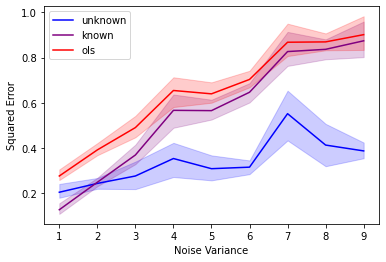

In [40]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()

In [27]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

,unknown_param_mse,var
0,0.242757,1.0
1,0.245554,2.0
2,0.343348,3.0
3,0.367010,4.0
4,0.163423,5.0
...,...,...
85,0.403906,5.0
86,0.798757,6.0
87,0.550839,7.0
88,0.251145,8.0


In [39]:
for v in range(1, 10): 
    unknown = unknown.drop(unknown[unknown['var'] == v].idxmax())
    unknown = unknown.drop(unknown[unknown['var'] == v].idxmin())
    known = known.drop(known[known['var'] == v].idxmax())
    known = known.drop(known[known['var'] == v].idxmin())
    ols = ols.drop(ols[ols['var'] == v].idxmax())
    ols = ols.drop(ols[ols['var'] == v].idxmin())